##Importing libraries

In [ ]:
# loading libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_ta as ta
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor,MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import pandas_datareader as web
import tensorflow as tf
from tensorflow import keras
import yfinance as yf

# Ticker selection

In [ ]:
# Get a ticker of choice this can be any ticker mac donalds apply etc
ticker='MCD'
# loading dates
start=dt.datetime(2018,1,1)
end=dt.datetime.now()
# getting stock
df=yf.download(ticker,start=start,end=end)



[*********************100%***********************]  1 of 1 completed


In [ ]:
# pivot it longer
df=df.stack()


In [ ]:
# get an overview of the data
df.describe()

Price,Close,High,Low,Open,Volume
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03
mean,216.300124,217.954276,214.580253,216.280493,3.304442e+06
std,50.680743,50.918239,50.406355,50.654919,1.581271e+06
min,122.171989,126.280084,110.703369,120.478885,1.047700e+06
25%,172.484879,173.711452,171.059364,172.495177,2.371200e+06
50%,217.755798,219.399531,216.415071,217.948641,2.926700e+06
75%,258.386841,259.684804,256.324459,258.343761,3.728200e+06
max,321.290009,326.320007,315.739990,320.089996,1.879200e+07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1825 entries, (Timestamp('2018-01-02 00:00:00'), 'MCD') to (Timestamp('2025-04-04 00:00:00'), 'MCD')
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1825 non-null   float64
 1   High    1825 non-null   float64
 2   Low     1825 non-null   float64
 3   Open    1825 non-null   float64
 4   Volume  1825 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 155.7+ KB


# Data Vizualization

<Axes: title={'center': 'MCD Closing Price'}, xlabel='Date'>

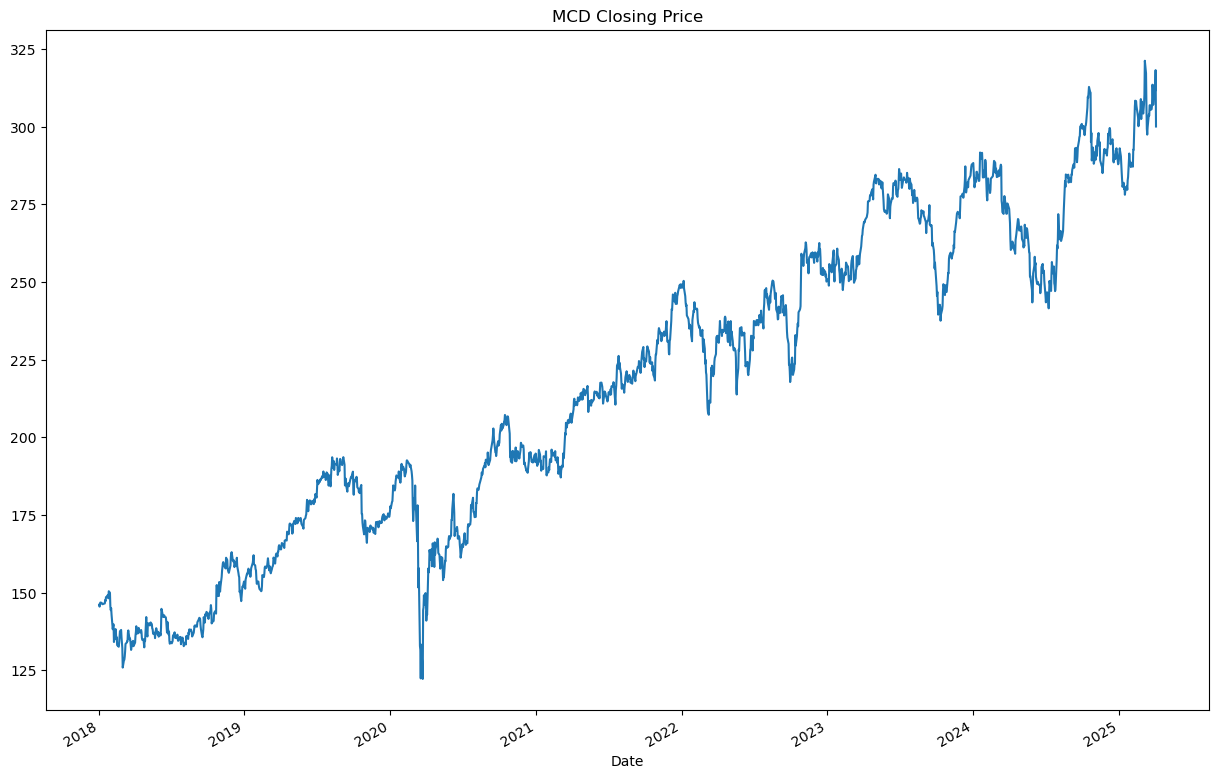

In [ ]:
%matplotlib inline
#Data visualization

import matplotlib as plt
df.xs(ticker,level=1)['Close'].plot(figsize=(15,10),title=f'{ticker} Closing Price')


Calculate the log returns

<Axes: title={'center': 'MCD Return Price'}, xlabel='Date'>

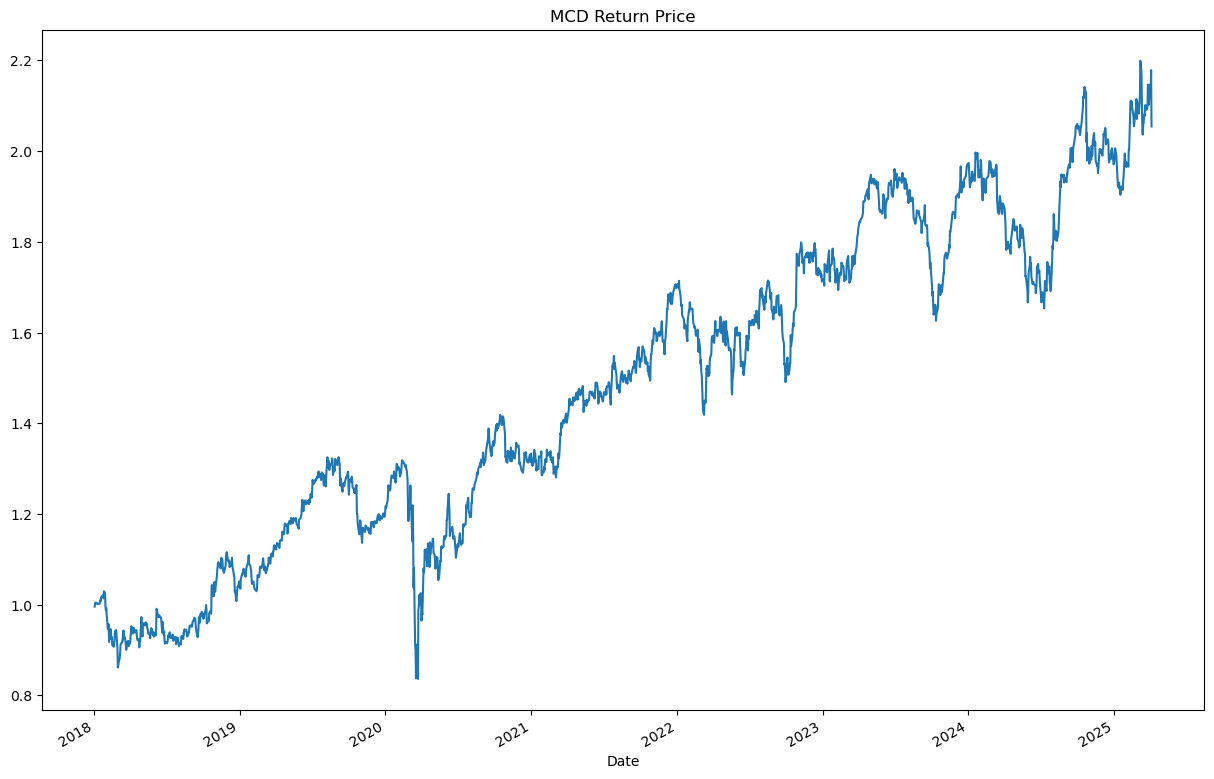

In [ ]:
#calculating the log returns so we can see how much u would make if you held on to the stock
df['returns']=np.log(df['Close']/df['Close'].shift(1))
# visualize the returns
import matplotlib as plt
df.xs(ticker,level=1)['returns'].cumsum().apply(np.exp).plot(figsize=(15,10),title=f'{ticker} Return Price')


## Lookback Window: Past 63 Trading Days


In [ ]:
# since the stock uses past data we need to make it look backwards for patterns we use the past 63 days
lag=63

lag_cols=[]
# stock goes up or down based on the returns sign
df['direction']=np.where(df['returns']>0,1,0)
# add the lags which means past days by shifting the returns to the previous day 63 times for 63 days
for i in range(1,lag+1):
    col=f'lag_{i}'
    df[col]=df['returns'].shift(i)
    lag_cols.append(col)

In [ ]:
# drop missing values
df.dropna(inplace=True)

## Technical Indicator Calculation for Prediction Features


In [ ]:
# calculate technical indicators which will be our parameters
df['sma'] = df['Close'].rolling(window=20).mean()
df['sd'] = df['Close'].rolling(window=20).std()
df['up'] = df['sma'] + 2 * df['sd']
df['lb'] = df['sma'] - 2 * df['sd']



In [ ]:
# calculating relative strength index
df['rsi']=ta.rsi(df['Close'])

In [ ]:
# calculating macd
macd=ta.macd(df['Close'],talib=True)

In [ ]:
result =pd.concat([df,macd],axis=1,)

## Data Splitting


In [ ]:

# drop missing values
result.dropna(inplace=True)
idx=int(len(result)*0.8)

#Here we split the data in order to test with unseen data which will not be used in making the algorthim learn
train=result.iloc[:idx]
test=result.iloc[idx:]


## Feature–Target Split (X / y)


In [ ]:

X_train=train.drop(['direction'],axis=1)
X_test=test.drop(['direction'],axis=1)
y_test=test['direction']
y_train=train['direction']

To avoid the model overfitting we remove any columns that would allow it to predict via data leakage or anything that would give it an unrealistic foresight to the future

In [ ]:
# removing leakage columns
cols=X_train.columns[6:]

In [ ]:
X_train[cols]

,,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_62,lag_63,sma,sd,up,lb,rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
2018-05-22,MCD,0.003101,-0.002048,-0.009625,-0.001165,-0.010129,-0.004059,0.001937,0.005040,-0.003222,-0.001395,...,0.012653,0.009373,137.832432,2.486959,142.806349,132.858514,41.101567,0.176482,-0.669975,0.846457
2018-05-23,MCD,-0.012650,0.003101,-0.002048,-0.009625,-0.001165,-0.010129,-0.004059,0.001937,0.005040,-0.003222,...,0.014828,0.012653,138.073458,2.135805,142.345069,133.801847,48.069256,0.129913,-0.573235,0.703148
2018-05-24,MCD,0.013517,-0.012650,0.003101,-0.002048,-0.009625,-0.001165,-0.010129,-0.004059,0.001937,0.005040,...,0.003184,0.014828,138.221554,1.999268,142.220090,134.223018,50.315366,0.144077,-0.447257,0.591334
2018-05-25,MCD,0.004753,0.013517,-0.012650,0.003101,-0.002048,-0.009625,-0.001165,-0.010129,-0.004059,0.001937,...,-0.018012,0.003184,138.429906,1.779194,141.988294,134.871518,52.663387,0.209046,-0.305830,0.514877
2018-05-29,MCD,0.005037,0.004753,0.013517,-0.012650,0.003101,-0.002048,-0.009625,-0.001165,-0.010129,-0.004059,...,-0.012036,-0.018012,138.140504,1.613209,141.366923,134.914086,45.369985,0.082219,-0.346126,0.428345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,MCD,-0.004402,-0.000893,0.003875,0.003815,0.018457,-0.000763,0.007735,0.017019,-0.000274,-0.008563,...,0.000658,0.003540,250.624403,6.210226,263.044856,238.203951,59.184661,1.642936,1.673924,-0.030988
2023-11-10,MCD,-0.002171,-0.004402,-0.000893,0.003875,0.003815,0.018457,-0.000763,0.007735,0.017019,-0.000274,...,-0.001767,0.000658,251.564268,5.868152,263.300571,239.827964,60.632083,1.800201,1.464951,0.335250
2023-11-13,MCD,0.003292,-0.002171,-0.004402,-0.000893,0.003875,0.003815,0.018457,-0.000763,0.007735,0.017019,...,-0.010110,-0.001767,252.493520,5.602788,263.699095,241.287945,62.902125,2.011437,1.340950,0.670487


## Decision Tree Algorithm

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()
tree.fit(X_train[cols],y_train)

DecisionTreeClassifier()

In [ ]:
# get the predictions
predictions=tree.predict(X_test[cols])

In [ ]:
from sklearn.metrics import classification_report

# Evaluation

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.53      0.52      0.52       162
           1       0.58      0.59      0.58       184

    accuracy                           0.55       346
   macro avg       0.55      0.55      0.55       346
weighted avg       0.55      0.55      0.55       346



## Accuracy Analysis (55%)


In [ ]:
# make the long positions 1 and shorts -1 in order to calculate returns from predictions
X_test['tree_predictions']=np.where(predictions>0,1,-1)
# multiply it with the return to get the returns from the strategy
X_test['tree_strategy']=(X_test['returns']*X_test['tree_predictions'])
# we can compare by summing both

X_test[['tree_strategy','returns']].sum().apply(np.exp)

tree_strategy    1.987397
returns          1.150227
dtype: float64

## Return Comparison
The prediction-based strategy yields marginally higher returns compared to the baseline.


<Axes: title={'center': 'Tree Strategy versus normal returns'}, xlabel='Date'>

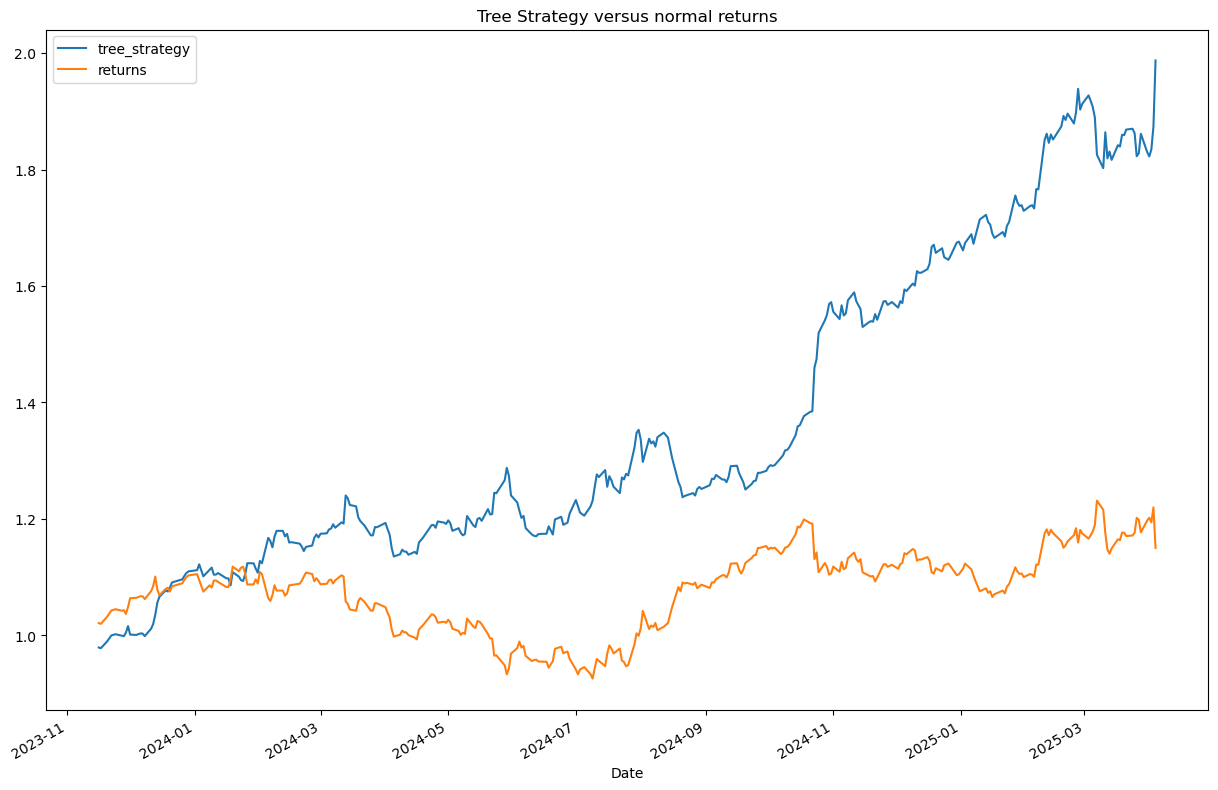

In [ ]:
X_test['tree_predictions']=np.where(predictions>0,1,-1)

X_test['tree_strategy']=(X_test['returns']*X_test['tree_predictions'])
X_test.xs(ticker,level=1)[['tree_strategy','returns']].cumsum().apply(np.exp).plot(figsize=(15,10),title='Tree Strategy versus normal returns')

As we can see, using the model’s predictions yields better results on the unseen test data.
This closely mirrors a real-world scenario in which future outcomes are unknown.


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic=LogisticRegression(solver='lbfgs')
logistic.fit(X_train[cols],y_train)
logistic_predictions=logistic.predict(X_test[cols])
print(classification_report(y_test,logistic_predictions))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       162
           1       0.73      0.67      0.70       184

    accuracy                           0.69       346
   macro avg       0.69      0.69      0.69       346
weighted avg       0.69      0.69      0.69       346



## Model Accuracy Comparison
The model achieves 69% accuracy, which is relatively high compared to the Decision Tree algorithm.


In [ ]:
X_train[cols]

,,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_62,lag_63,sma,sd,up,lb,rsi,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
2018-05-22,MCD,0.003101,-0.002048,-0.009625,-0.001166,-0.010129,-0.004060,0.001937,0.005041,-0.003222,-0.001395,...,0.012653,0.009373,137.832430,2.486963,142.806355,132.858504,41.101409,0.176479,-0.669977,0.846456
2018-05-23,MCD,-0.012651,0.003101,-0.002048,-0.009625,-0.001166,-0.010129,-0.004060,0.001937,0.005041,-0.003222,...,0.014828,0.012653,138.073456,2.135809,142.345073,133.801838,48.069236,0.129910,-0.573237,0.703147
2018-05-24,MCD,0.013518,-0.012651,0.003101,-0.002048,-0.009625,-0.001166,-0.010129,-0.004060,0.001937,0.005041,...,0.003184,0.014828,138.221549,1.999273,142.220096,134.223003,50.315280,0.144072,-0.447260,0.591332
2018-05-25,MCD,0.004753,0.013518,-0.012651,0.003101,-0.002048,-0.009625,-0.001166,-0.010129,-0.004060,0.001937,...,-0.018012,0.003184,138.429901,1.779201,141.988302,134.871500,52.663390,0.209042,-0.305832,0.514874
2018-05-29,MCD,0.005037,0.004753,0.013518,-0.012651,0.003101,-0.002048,-0.009625,-0.001166,-0.010129,-0.004060,...,-0.012036,-0.018012,138.140500,1.613216,141.366931,134.914069,45.370038,0.082216,-0.346127,0.428342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,MCD,-0.004402,-0.000893,0.003875,0.003815,0.018457,-0.000763,0.007735,0.017019,-0.000274,-0.008563,...,0.000658,0.003540,250.624406,6.210229,263.044863,238.203948,59.184611,1.642935,1.673923,-0.030988
2023-11-10,MCD,-0.002170,-0.004402,-0.000893,0.003875,0.003815,0.018457,-0.000763,0.007735,0.017019,-0.000274,...,-0.001768,0.000658,251.564272,5.868150,263.300572,239.827971,60.632027,1.800200,1.464950,0.335250
2023-11-13,MCD,0.003292,-0.002170,-0.004402,-0.000893,0.003875,0.003815,0.018457,-0.000763,0.007735,0.017019,...,-0.010110,-0.001768,252.493520,5.602783,263.699086,241.287954,62.901964,2.011431,1.340945,0.670486


## Logistic Regression: Accuracy and Test Evaluation


<Axes: title={'center': 'Normal MCD Return'}, xlabel='Date'>

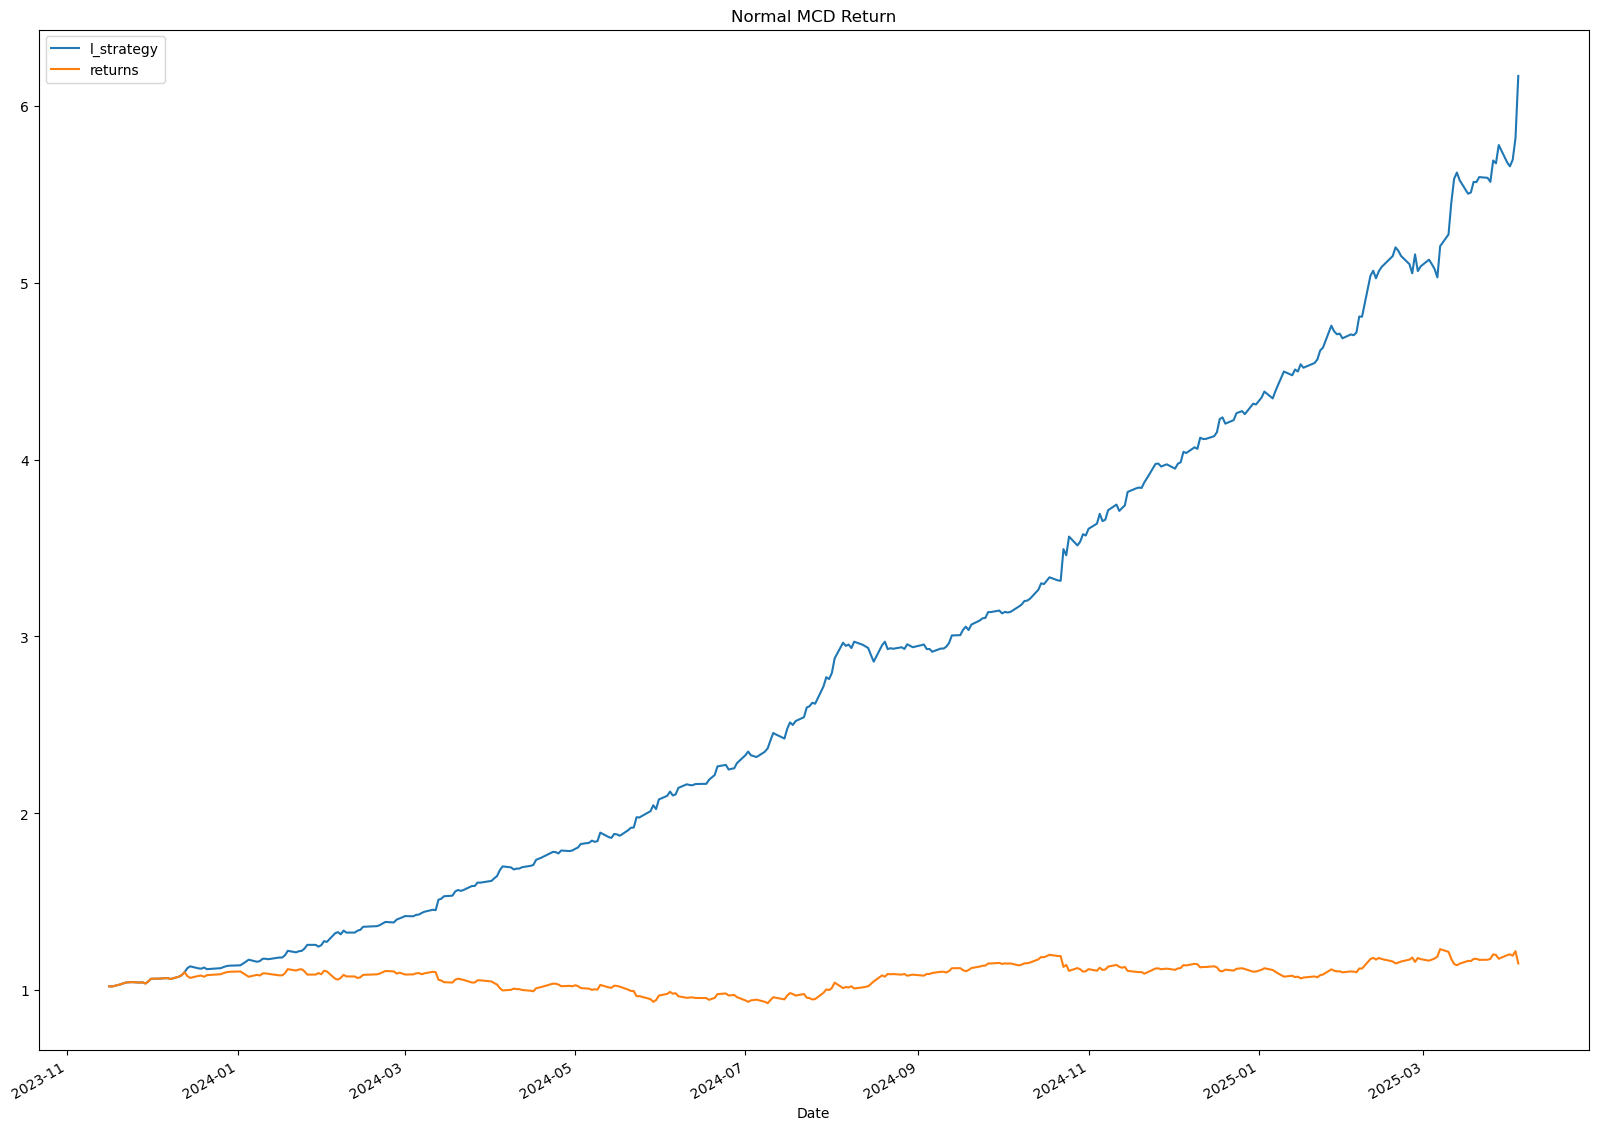

In [ ]:
X_test['l_predictions']=np.where(logistic_predictions>0,1,-1)

X_test['l_strategy']=(X_test['returns']*X_test['l_predictions'])

X_test.xs(ticker,level=1)[['l_strategy','returns']].cumsum().apply(np.exp).plot(figsize=(20,15),title=f'logistic regression versus baseline {ticker} Return')

In [ ]:
X_test[['l_strategy','returns']].sum().apply(np.exp)

l_strategy    6.170951
returns       1.150227
dtype: float64

## Return Comparison with Baseline
As observed, this model outperforms the Decision Tree, generating approximately six times the returns of a simple buy-and-hold strategy, which is a significant improvement.


In [ ]:
# Random forest algorithm
forest=RandomForestClassifier().fit(X_train[cols],y_train)
forest_predictions=forest.predict(X_test[cols])
print(classification_report(y_test,forest_predictions))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       162
           1       0.67      0.60      0.64       184

    accuracy                           0.63       346
   macro avg       0.63      0.63      0.63       346
weighted avg       0.64      0.63      0.63       346



## Model Accuracy and Expected Returns
This model achieves 64% accuracy, slightly lower than before. We can expect similar predictive behavior, although the resulting returns are likely not as high as those from Logistic Regression.


<Axes: title={'center': 'Strategy Versus Normal MCD Returns'}, xlabel='Date'>

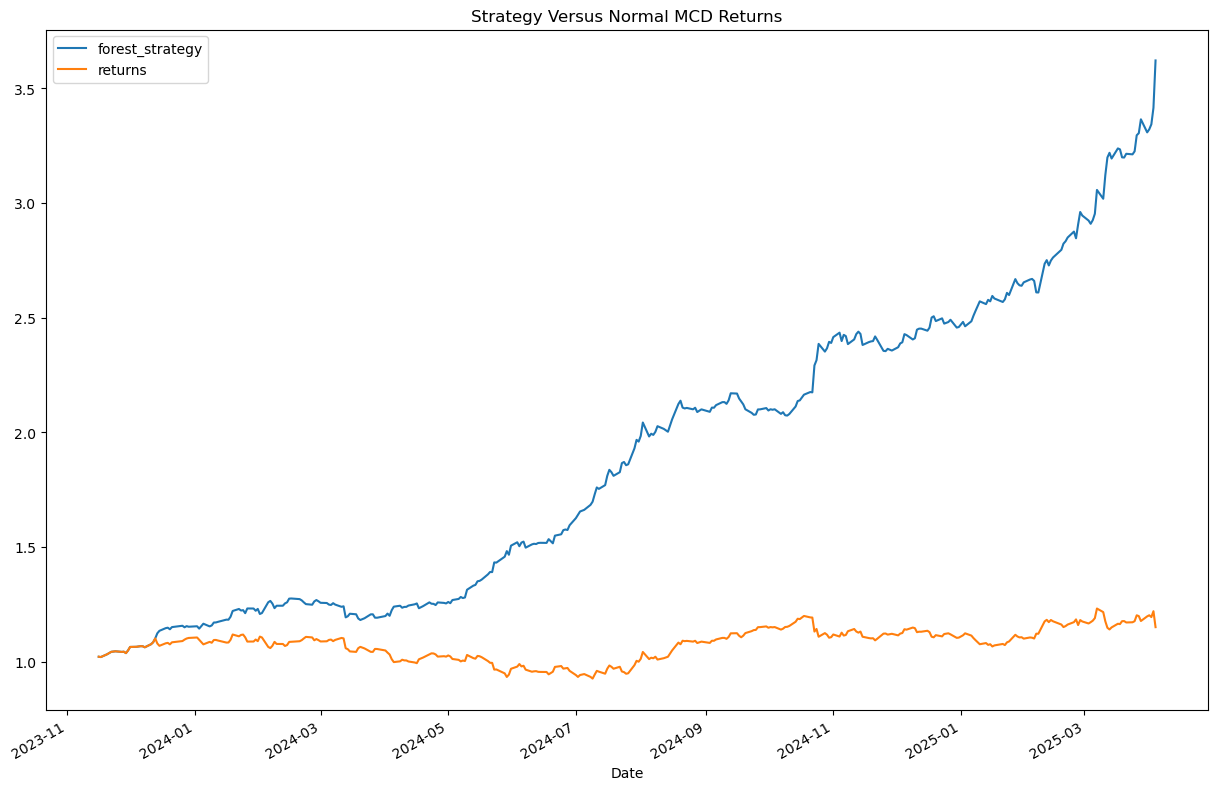

In [ ]:
X_test['forest_predictions']=np.where(forest_predictions>0,1,-1)
X_test['forest_strategy']=(X_test['returns']*X_test['forest_predictions'])
X_test.xs(ticker,level=1)[['forest_strategy','returns']].cumsum().apply(np.exp).plot(figsize=(15,10),title=f'Strategy Versus Normal {ticker} Returns')


In [ ]:
X_test[['forest_strategy','returns']].sum().apply(np.exp)

forest_strategy    3.621628
returns            1.150227
dtype: float64

## Impact of Accuracy on Returns
Although the difference in accuracy is small, it has a significant impact on returns.
This model yields only approximately three times the returns of a buy-and-hold strategy, compared to higher-performing models.


# Gradient Boosting Strategy

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier().fit(X_train[cols],y_train)
clf.score(X_test[cols],y_test)



0.7109826589595376

## Gradient Boosting Performance
The Gradient Boosting model achieves 71% accuracy, the highest so far.
We can reasonably expect it to outperform the previous models in terms of returns.


gboost_strategy    6.812328
returns            1.150227
dtype: float64

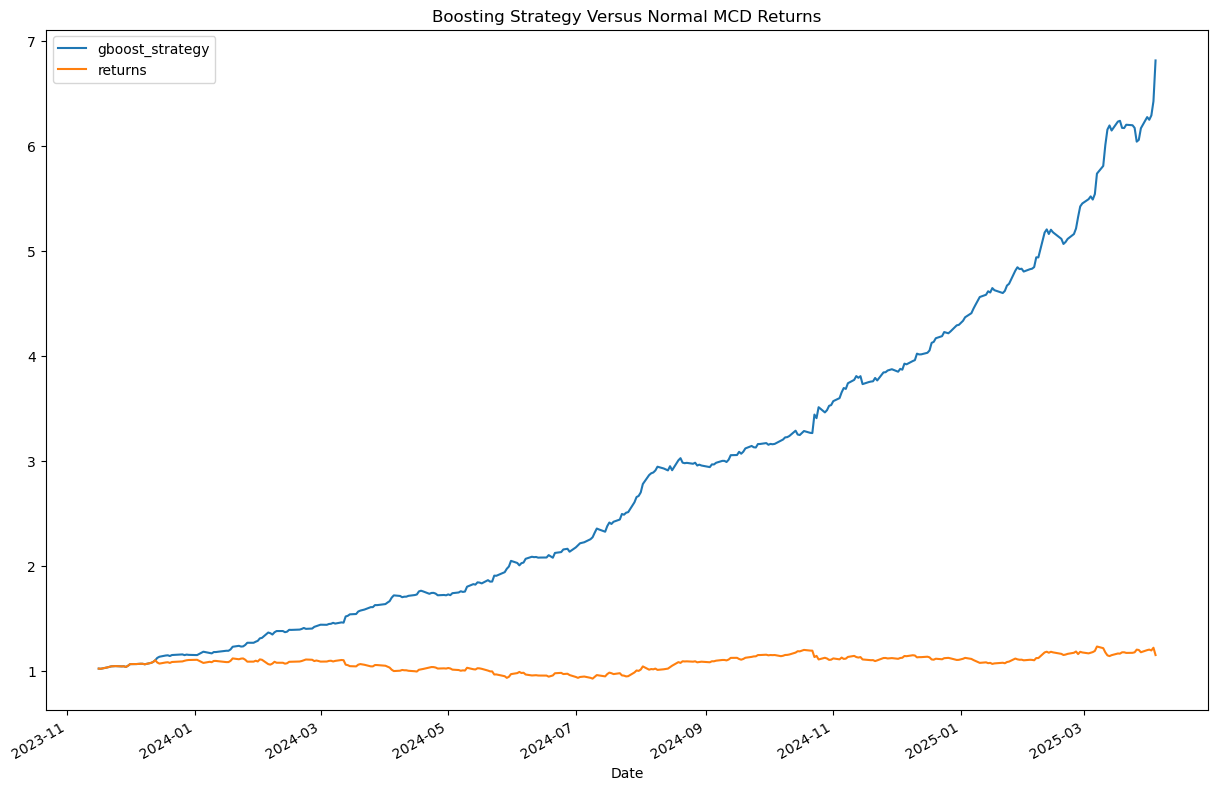

In [ ]:
g_boost_pred=clf.predict(X_test[cols])
X_test['gboost_predictions']=np.where(g_boost_pred>0,1,-1)

X_test['gboost_strategy']=(X_test['returns']*X_test['gboost_predictions'])
X_test.xs(ticker,level=1)[['gboost_strategy','returns']].cumsum().apply(np.exp).plot(figsize=(15,10),title=f'Boosting Strategy Versus Normal {ticker} Returns')
X_test[['gboost_strategy','returns']].sum().apply(np.exp)

Now lets try an artificial neural network

In [ ]:
# use multi layer peceptron
mlp=MLPClassifier()
# normalize the data for better predictions
def scale(df):
    mean=df.mean()
    scaled=(df-mean)/df.std()
    return scaled


X_train_scaled=scale(X_train)
X_test_scaled=scale(X_test)

mlp.fit(X_train_scaled[cols],y_train)

C:\Users\Thato\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

## Neural Networks: Feature Scaling
With Neural Networks, feature scaling significantly affects accuracy, so applying a scaling function is necessary.



In [ ]:

mlp_pred=mlp.predict(X_test_scaled[cols])
print(classification_report(y_test,mlp_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       162
           1       0.69      0.74      0.71       184

    accuracy                           0.68       346
   macro avg       0.68      0.68      0.68       346
weighted avg       0.68      0.68      0.68       346



## Neural Network Accuracy
The Neural Network achieves 68% accuracy, which is comparable to Logistic Regression.


<Axes: title={'center': 'Strategy Versus Normal MCD Returns'}, xlabel='Date'>

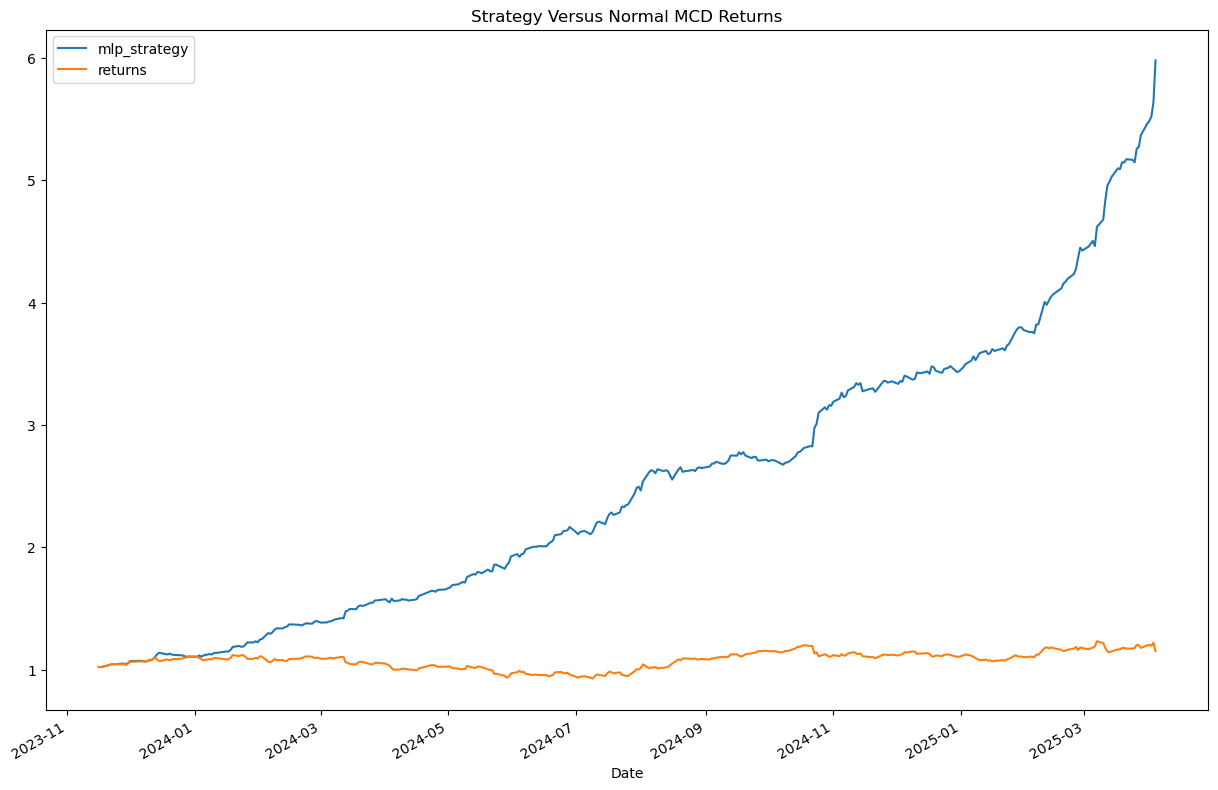

In [ ]:

X_test['mlp_predictions']=np.where(mlp_pred>0,1,-1)
X_test['mlp_strategy']=(X_test['returns']*X_test['mlp_predictions'])
X_test.xs(ticker,level=1)[['mlp_strategy','returns']].cumsum().apply(np.exp).plot(figsize=(15,10),title=f'Strategy Versus Normal {ticker} Returns')


In [ ]:
X_test[['mlp_strategy','returns']].sum().apply(np.exp)

mlp_strategy    5.978592
returns         1.150227
dtype: float64

## Performance Comparison
The Neural Network performs almost as well as Logistic Regression in terms of accuracy.


## Deep Neural Network (TensorFlow)
We now implement a Deep Neural Network using TensorFlow. This is the most complex model so far,
consisting of multiple layers with nonlinear activations and trained using backpropagation.


In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Activation,LSTM,Dropout,BatchNormalization

In [ ]:
model=Sequential()

In [ ]:
model.add(Dense(len(cols),activation='relu',input_shape=(len(cols),)))
model.add(Dense(1000,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(250,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
model.fit(X_train_scaled[cols],y_train,epochs=50,validation_data=(X_test_scaled[cols],y_test))

Epoch 1/50
44/44 [==============================] - 3s 34ms/step - loss: 0.6977 - accuracy: 0.5572 - val_loss: 0.6926 - val_accuracy: 0.5289
Epoch 2/50
44/44 [==============================] - 1s 26ms/step - loss: 0.6414 - accuracy: 0.6462 - val_loss: 0.6741 - val_accuracy: 0.5954
Epoch 3/50
44/44 [==============================] - 1s 26ms/step - loss: 0.5484 - accuracy: 0.7402 - val_loss: 0.7022 - val_accuracy: 0.6185
Epoch 4/50
44/44 [==============================] - 1s 26ms/step - loss: 0.4319 - accuracy: 0.8140 - val_loss: 0.7818 - val_accuracy: 0.6156
Epoch 5/50
44/44 [==============================] - 1s 26ms/step - loss: 0.3018 - accuracy: 0.8748 - val_loss: 0.8449 - val_accuracy: 0.6474
Epoch 6/50
44/44 [==============================] - 1s 25ms/step - loss: 0.2046 - accuracy: 0.9204 - val_loss: 1.2656 - val_accuracy: 0.6156
Epoch 7/50
44/44 [==============================] - 1s 29ms/step - loss: 0.1517 - accuracy: 0.9385 - val_loss: 1.2679 - val_accuracy: 0.6734
Epoch 8/50
44

## Deep Neural Network Accuracy
The Deep Neural Network achieves 67% accuracy, which is lower than Logistic Regression but higher than several other models we tested.


11/11 [==============================] - 0s 9ms/step


<Axes: title={'center': 'Deep Learning Strategy'}, xlabel='Date'>

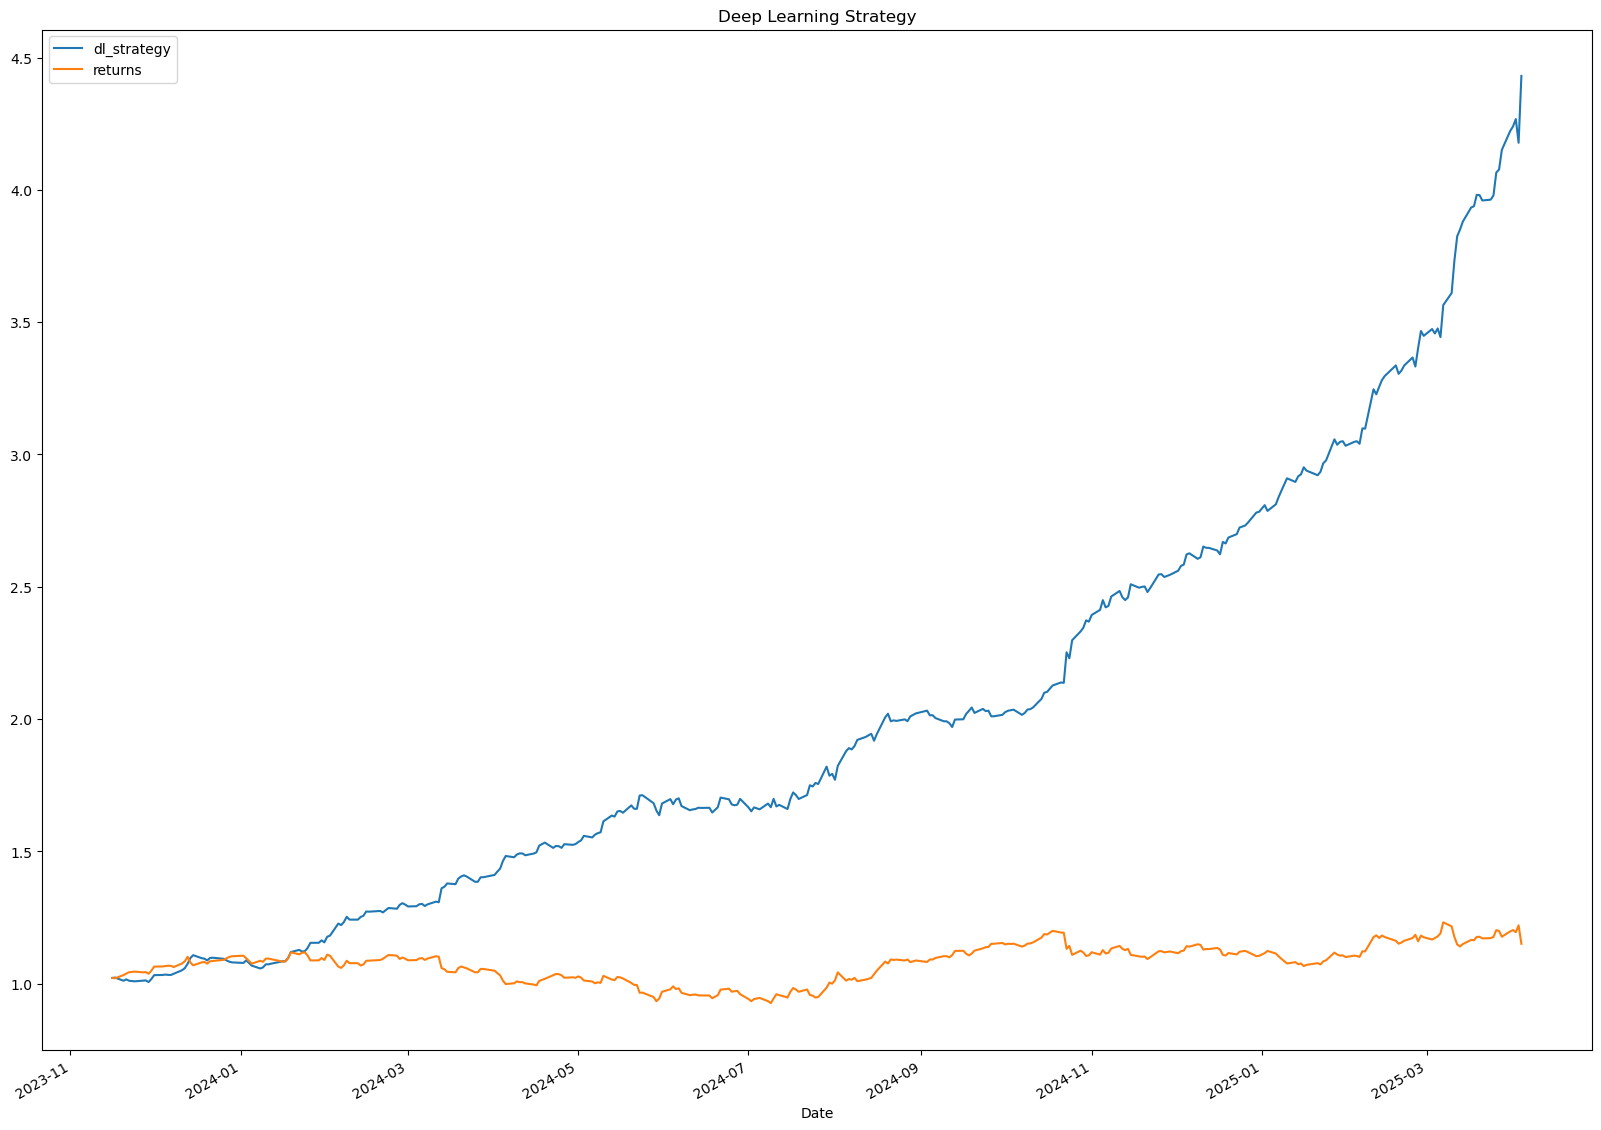

In [ ]:
dl_pred=np.where(model.predict(X_test_scaled[cols])>0.5,1,0)

X_test['dl_predictions']=np.where(dl_pred>0,1,-1)

X_test['dl_strategy']=(X_test['returns']*X_test['dl_predictions'])
X_test.xs(ticker,level=1)[['dl_strategy','returns']].cumsum().apply(np.exp).plot(figsize=(20,15),title='Deep Learning Strategy')


In [ ]:
X_test[['dl_strategy','returns']].sum().apply(np.exp)

dl_strategy    4.430824
returns        1.150227
dtype: float64

# Final thoughts

## Model Performance Summary
The best-performing algorithm was Gradient Boosting. Its main advantage is that it does not make strong assumptions about the data, allowing it to generalize better and learn underlying patterns without bias.

Logistic Regression, a high-bias algorithm, performed well among parameterized and biased models. However, it is sensitive to unusual events that deviate from its assumptions. Despite this, over hundreds of days, it produced a respectable return—approximately six times what a simple buy-and-hold strategy would yield.
